<a href="https://colab.research.google.com/github/2025-02-FML-team/WV-Team/blob/main/notebooks/03_model_build.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Training

일단 피드백 대로 싱글몰트 카테고리만 추가적으로 더 도수에 따라서 카테고리를 나누었으며, 그것에 따라서 성능 측정을 할 계획입니다.
Colab을 이용 중이라고 하시면 content안에 미리 빌드된 파일을 넣거나, drive에 연결할때 까지 기다리면 됩니다.

### Data Split

In [ ]:
import os
from pathlib import Path

try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    PACK_PATH = Path('/content/drive/My Drive/colab_drive/prepacked.zip')
    DATA_DIR = Path('/content/unpacked')

    # unzip 실행
    !mkdir -p /content/unpacked
    !unzip -q "/content/drive/My Drive/colab_drive/prepacked.zip" -d "/content/unpacked"
else:
    DATA_DIR= Path(os.path.join(os.getcwd(), "../data/")).resolve()
DATA_DIR

PosixPath('/Volumes/Backup/Workspace/ML/WV-Team/data')

In [2]:
import re
import glob
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm.notebook import tqdm
from tensorflow import keras
from tensorflow.keras import layers

# CSV 로드 및 정리, 본인 경로에 맞게 변환
CSV_PATH = DATA_DIR / 'whiskies_recategorized.csv'
IMAGE_SIZE = (256, 256)
#RANDOM_STATE = 42

In [3]:
df = pd.read_csv(CSV_PATH, dtype={"id": str})
df["id"] = df["id"].astype(str).str.strip().str.replace(r"\.0$", "", regex=True)
df["category"] = df["category"].astype(str).str.strip()
paths = [DATA_DIR / p for p in df["local_full_path"]]

bar = tqdm(paths, desc="Processing Images", unit="img")

# 이미지 로드
X_list = []
for p in bar:
    with Image.open(p) as im:
        im = im.convert("RGB")
        im = im.resize(IMAGE_SIZE)
        arr = np.asarray(im, dtype=np.uint8)
        X_list.append(arr)
X = np.stack(X_list, axis=0)

Processing Images:   0%|          | 0/2943 [00:00<?, ?img/s]

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np

# 라벨 인코딩
labels = df["category"].values
le = LabelEncoder()
y_int = le.fit_transform(labels)

# test 분리
X_rest, X_test, y_rest, y_test = train_test_split(
    X, y_int,
    test_size=0.2,
    #random_state=RANDOM_STATE,
    stratify=y_int
)

# train / valid 분리
X_train, X_valid, y_train, y_valid = train_test_split(
    X_rest, y_rest,
    test_size=0.2,
    #random_state=RANDOM_STATE,
    stratify=y_rest
)

print("X_train:", X_train.shape)
print("X_valid:", X_valid.shape)
print("X_test :", X_test.shape)

print("y_train 분포:", np.bincount(y_train))
print("y_valid 분포:", np.bincount(y_valid))
print("y_test  분포:", np.bincount(y_test))

print("class mapping:", dict(zip(le.classes_, range(len(le.classes_)))))

X_train: (1883, 256, 256, 3)
X_valid: (471, 256, 256, 3)
X_test : (589, 256, 256, 3)
y_train 분포: [316 148  97 468  49 147 155 503]
y_valid 분포: [ 79  37  24 117  12  37  39 126]
y_test  분포: [ 99  46  30 146  15  46  49 158]
class mapping: {'Blended': 0, 'Bourbon': 1, 'Brandy': 2, 'Other': 3, 'Rye': 4, 'SM_40_43': 5, 'SM_43_46': 6, 'SM_G46': 7}


In [5]:
X_train = X_train.astype("float32", copy=False)
X_valid = X_valid.astype("float32", copy=False)
X_test = X_test.astype("float32", copy=False)
X_train /= 255;
X_valid /= 255;
X_test /= 255;

In [6]:
print(X_train.shape, y_train.dtype)
print(X_train.shape, y_train[:10])

(1883, 256, 256, 3) int64
(1883, 256, 256, 3) [1 2 7 7 3 7 0 2 3 1]


### Baseline

여기서부터는 강의록2에 있는 코드를 변형한 것입니다.
만약 미리 만들어진 model을 사용하고 싶다면, 아래에 있는 주석을 해제해주시면 되겠습니다.

In [7]:
MODEL_PATH = DATA_DIR / 'models' / 'model_baseline_v1.keras'
#만약 이미 만들어진 모델을 가져오고 싶으면 이렇게 하면 됩니다.
#model = keras.models.load_model(MODEL_PATH)

In [19]:
model = keras.Sequential([
    keras.Input(shape=(256, 256, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(300, activation='gelu'),
    layers.Dense(300, activation='gelu'),
    layers.Dense(8, activation='softmax'),
])

In [20]:
model.compile(optimizer= "rmsprop",
              loss = "sparse_categorical_crossentropy",
              metrics=["val_macro_f1"])

방법2를 골랐을 경우 128 * 128 * 3을 128 * 256 * 3으로 바꿔주세요

In [13]:
model.fit(train_images, train_labels, epochs=50, batch_size=128)

Epoch 1/50


2025-11-13 16:11:46.612041: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


19/19 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.2413 - loss: 7.4414
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.3309 - loss: 2.0709
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.4244 - loss: 1.6961
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 60s 3s/step - accuracy: 0.4435 - loss: 1.6552
Epoch 5/50
 6/19 ━━━━━━━━━━━━━━━━━━━━ 49s 4s/step - accuracy: 0.4482 - loss: 1.5969

KeyboardInterrupt: 

In [15]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(test_acc)

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.5959 - loss: 3.3220
0.5959252715110779


In [13]:
model.save(MODEL_PATH)

In [17]:
from sklearn.metrics import classification_report

y_pred = model.predict(test_images)
y_pred = np.argmax(y_pred, axis=1)

# classification report 출력
print(classification_report(test_labels, y_pred, target_names=[
    "Blended",
    "Bourbon",
    "Brandy",
    "Other",
    "Rye",
    "SM_40_43",
    "SM_43_46",
    "SM_G46"
]))

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
              precision    recall  f1-score   support

     Blended       0.56      0.49      0.52        99
     Bourbon       0.50      0.57      0.53        46
      Brandy       0.73      0.37      0.49        30
       Other       0.76      0.80      0.78       146
         Rye       0.25      0.20      0.22        15
    SM_40_43       0.43      0.28      0.34        46
    SM_43_46       0.43      0.24      0.31        49
      SM_G46       0.57      0.76      0.65       158

    accuracy                           0.60       589
   macro avg       0.53      0.46      0.48       589
weighted avg       0.59      0.60      0.58       589



In [1]:
#history가 없어진 관계로 수동 복원
train_accuracy = [
    0.3207, 0.4435, 0.4601, 0.4766, 0.4928,
    0.5042, 0.5280, 0.5833, 0.5964, 0.6869,
    0.7247, 0.8105, 0.8653, 0.9002, 0.9482,
    0.9142, 0.9830, 0.9796, 0.9745, 0.9868,
    0.9830, 0.9877, 0.9928, 0.9941, 0.9044,
    0.9949, 0.9970, 0.9966, 0.9966, 0.9609,
    0.9979, 0.9966, 0.9936, 0.9907, 0.9975,
    0.9949, 0.9941, 0.9962, 0.9749, 0.9962,
    0.9987, 0.9979, 0.9953, 0.9894, 0.9796,
    0.9979, 0.9979, 0.9983, 0.9987
]

train_loss = [
    3.1700, 1.6356, 1.5615, 1.4909, 1.4086,
    1.3526, 1.3108, 1.1407, 1.0780, 0.8652,
    0.7648, 0.5292, 0.4242, 0.2971, 0.1674,
    0.3081, 0.0575, 0.0631, 0.0811, 0.0367,
    0.0639, 0.0357, 0.0214, 0.0180, 0.4682,
    0.0265, 0.0093, 0.0116, 0.0079, 0.1585,
    0.0074, 0.0074, 0.0179, 0.0347, 0.0068,
    0.0141, 0.0184, 0.0090, 0.0967, 0.0077,
    0.0032, 0.0033, 0.0150, 0.0394, 0.0786,
    0.0058, 0.0032, 0.0028, 0.0027, 0.0031
]

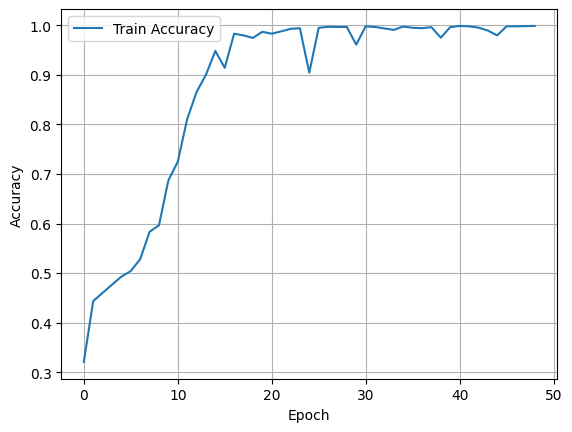

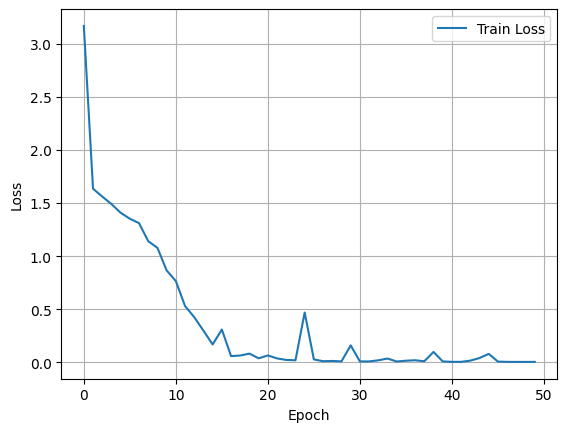

In [2]:
import matplotlib.pyplot as plt

plt.plot(train_accuracy, label="Train Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()
plt.show()

plt.plot(train_loss, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.show()

### Model Search

In [7]:
MODEL_PATH = DATA_DIR / 'models' / 'model_train_v1.keras'
CHECK_DIR = DATA_DIR / 'models' / 'chkpoint'

CHECK_DIR.mkdir(parents=True, exist_ok=True)

In [18]:
from sklearn.metrics import f1_score
from tensorflow.keras.callbacks import Callback

class F1ScoreCallback(Callback):
    def __init__(self, X_val, y_val, start_from_epoch=12, patient=3):
        super().__init__()
        self.X_val = X_val
        self.y_val = y_val
        self.f1_scores = [] #this is for cumilating f1 per epoch
        self.start_from_epoch = start_from_epoch
        self.patient = patient
        self.out = 0
        self.best_f1 = -1

    def on_epoch_end(self, epoch, logs=None):
        y_pred = self.model.predict(self.X_val, verbose=0)
        y_pred = np.argmax(y_pred, axis=1)

        if self.y_val.ndim == 2:
            y_true = np.argmax(self.y_val, axis=1)
        else:
            y_true = self.y_val

        f1 = f1_score(y_true, y_pred, average='macro')
        self.f1_scores.append(f1)
        logs['val_macro_f1'] = f1

        if f1 > self.best_f1:
            self.best_f1 = f1

        if 1 < epoch and epoch > self.start_from_epoch and f1 < self.f1_scores[-2]:
            print(f"\nNon Improvement detected at EP : {epoch}, f1 : {f1}")
            self.out += 1

        if self.out >= self.patient:
            print(f"\nStopping at EP : {epoch}, f1 : {f1}")
            self.model.stop_training = True

In [21]:
from tensorflow.keras import layers, models
from tensorflow.keras.activations import gelu

#the name keyword is just there to use kwargs, it's not actually used.
def build_model(dropout=0.3, use_bn=False, dense_act="relu", name=''):
    act = gelu if dense_act == "gelu" else dense_act

    inputs = keras.Input(shape=(256, 256, 3))
    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Flatten()(x)

    x = layers.Dense(300)(x)
    if use_bn:
        x = layers.BatchNormalization()(x)
    x = layers.Activation(act)(x)
    if dropout >= 0.0:
        x = layers.Dropout(dropout)(x)

    x = layers.Dense(300)(x)
    if use_bn:
        x = layers.BatchNormalization()(x)
    x = layers.Activation(act)(x)
    if dropout >= 0.0:
        x = layers.Dropout(dropout)(x)

    outputs = layers.Dense(8, activation='softmax')(x)
    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [22]:
from tensorflow.keras.callbacks import ModelCheckpoint

configs = [
    {"name": "relu", "dropout": 0.0, "use_bn": False, "dense_act": "relu"},
    {"name": "relu_do01", "dropout": 0.1, "use_bn": False, "dense_act": "relu"},
    {"name": "gelu", "dropout": 0.0, "use_bn": False, "dense_act": "gelu"},
    {"name": "gelu_bn", "dropout": 0.0, "use_bn": True, "dense_act": "gelu"},
    {"name": "gelu_do03", "dropout": 0.3, "use_bn": False, "dense_act": "gelu"},
    {"name": "gelu_do03_bn", "dropout": 0.3, "use_bn": True, "dense_act": "gelu"},
    {"name": "gelu_do05", "dropout": 0.5, "use_bn": False, "dense_act": "gelu"},
    {"name": "gelu_do05_bn", "dropout": 0.5, "use_bn": True, "dense_act": "gelu"},
]

In [17]:
results = []

for cfg in configs:
    print(f"\n=== Running {cfg['name']} ===")
    curr_model_path = CHECK_DIR / f"last_{cfg['name']}.keras"
    
    if curr_model_path.exists():
        print(f"[SKIP] {cfg['name']} exists, skipping")
        continue
        
    model = build_model(**cfg)

    f1_cb = F1ScoreCallback(X_valid, y_valid)

    checkpoint = ModelCheckpoint(
        CHECK_DIR / f"chk_{cfg['name']}.keras",
        monitor='val_macro_f1',
        save_best_only=True,
        mode='max'
    )

    history = model.fit(
        X_train, y_train,
        validation_data=(X_valid, y_valid),
        epochs=30,
        batch_size=128,
        callbacks=[f1_cb, checkpoint],
        verbose=1
    )

    model.save(curr_model_path)

    best_f1 = max(f1_cb.f1_scores)
    results.append((cfg["name"], best_f1))
    print(f"{cfg['name']} best val_macro_f1 = {best_f1:.4f}")


=== Running relu ===
[SKIP] relu exists, skipping

=== Running relu_do01 ===
[SKIP] relu_do01 exists, skipping

=== Running gelu ===
Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.2475 - loss: 4.6507 - val_accuracy: 0.3482 - val_loss: 1.8024 - val_macro_f1: 0.1161
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.3845 - loss: 1.7156 - val_accuracy: 0.4437 - val_loss: 1.6481 - val_macro_f1: 0.1467
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - accuracy: 0.4822 - loss: 1.5070 - val_accuracy: 0.4650 - val_loss: 1.5154 - val_macro_f1: 0.2484
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 53s 3s/step - accuracy: 0.5348 - loss: 1.3357 - val_accuracy: 0.5074 - val_loss: 1.4075 - val_macro_f1: 0.2969
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 59s 4s/step - accuracy: 0.5996 - loss: 1.1118 - val_accuracy: 0.5350 - val_loss: 1.5068 - val_macro_f1: 0.3716
Epoch 6/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - accuracy: 0.6814 - loss: 0.8898 - val_accuracy: 0.5053 - val_loss: 1.

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, precision_score
from tensorflow.keras import backend as K

# ----- 설정 값들 -----
N_SPLITS   = 5      # k-fold 개수
EPOCHS     = 20     # 최대 epoch
BATCH_SIZE = 128
RANDOM_STATE = 42   # 재현용 seed

# X_rest, y_rest 가 이미 있다고 가정 (test는 따로 빼둔 상태)
# configs 와 build_model(dropout, use_bn, dense_act) 도 있다고 가정

skf = StratifiedKFold(
    n_splits=N_SPLITS,
    shuffle=True,
    random_state=RANDOM_STATE,
)

cv_results = []

for cfg in configs:
    name = cfg["name"]
    print(f"\n===== K-Fold CV for config: {name} =====")

    fold_losses     = []
    fold_accuracies = []
    fold_precisions = []
    fold_f1s        = []
    fold_last_f1s   = []

    # k-fold 루프
    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X_rest, y_rest), start=1):
        print(f"\n[{name}] Fold {fold_idx}/{N_SPLITS}")

        X_tr, X_val = X_rest[train_idx], X_rest[val_idx]
        y_tr, y_val = y_rest[train_idx], y_rest[val_idx]

        # 이전 모델/그래프 정리 (메모리 누수 방지용)
        K.clear_session()

        # 모델 생성
        model = build_model(**cfg)

        # 대체
        f1_cb = F1ScoreCallback(X_val, y_val)

        history = model.fit(
            X_tr, y_tr,
            validation_data=(X_val, y_val),
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            callbacks=[f1_cb],
            verbose=1,   # 필요하면 1로 바꿔도 됨
        )

        # ---- 이 fold에서 metrics 계산 ----
        # 1) loss / accuracy (evaluate)
        loss, acc = model.evaluate(X_val, y_val, verbose=0)

        # 2) 예측값 가져와서 precision / f1 (macro) 계산
        y_prob = model.predict(X_val, verbose=0)
        y_pred = np.argmax(y_prob, axis=1)

        # y_val은 이미 정수 레이블이라고 가정 (LabelEncoder 사용)
        y_true = y_val

        precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
        f1        = f1_cb.best_f1
        last_f1   = f1_cb.f1_scores[-1]

        fold_losses.append(loss)
        fold_accuracies.append(acc)
        fold_precisions.append(precision)
        fold_f1s.append(f1)
        fold_last_f1s.append(last_f1)

        print(f"[{name}] Fold {fold_idx}: "
              f"loss={loss:.4f}, acc={acc:.4f}, "
              f"prec_macro={precision:.4f}, f1_macro={f1:.4f}")

    # ----- config별 평균/표준편차 정리 -----
    cfg_row = {
        "name": name,
        "dropout": cfg["dropout"],
        "use_bn": cfg["use_bn"],
        "dense_act": cfg["dense_act"],
        "loss_mean": float(np.mean(fold_losses)),
        "loss_std":  float(np.std(fold_losses)),
        "acc_mean":  float(np.mean(fold_accuracies)),
        "acc_std":   float(np.std(fold_accuracies)),
        "prec_macro_mean": float(np.mean(fold_precisions)),
        "prec_macro_std":  float(np.std(fold_precisions)),
        "best_f1_macro_mean":   float(np.mean(fold_f1s)),
        "best_f1_macro_std":    float(np.std(fold_f1s)),
        "last_f1_macro_mean":   float(np.mean(fold_last_f1s)),
        "last_f1_macro_std":    float(np.std(fold_last_f1s)),
    }

    print(f"\n>>> [CV Summary] {name}: "
          f"f1_macro={cfg_row['best_f1_macro_mean']:.4f} ± {cfg_row['best_f1_macro_std']:.4f}, "
          f"last_f1_macro={cfg_row['last_f1_macro_mean']:.4f} ± {cfg_row['last_f1_macro_std']:.4f}, "
          f"acc={cfg_row['acc_mean']:.4f} ± {cfg_row['acc_std']:.4f}, "
          f"loss={cfg_row['loss_mean']:.4f} ± {cfg_row['loss_std']:.4f}")

    cv_results.append(cfg_row)

# ----- 전체 config 결과를 테이블로 보기 -----
cv_df = pd.DataFrame(cv_results).sort_values("best_f1_macro_mean", ascending=False)
print("\n===== K-Fold 결과 (정렬: best_f1_macro_mean 내림차순) =====")
print(cv_df.to_string(index=False))


===== K-Fold CV for config: relu =====

[relu] Fold 1/5
Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.2156 - loss: 1045.2440 - val_accuracy: 0.2357 - val_loss: 2.5389 - val_macro_f1: 0.1200
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.3229 - loss: 2.0357 - val_accuracy: 0.2930 - val_loss: 1.9030 - val_macro_f1: 0.1091
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.3431 - loss: 1.7606 - val_accuracy: 0.2951 - val_loss: 2.0439 - val_macro_f1: 0.1933
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.4190 - loss: 3.4699 - val_accuracy: 0.3694 - val_loss: 2.2714 - val_macro_f1: 0.1697
Epoch 5/20
 8/15 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.4713 - loss: 1.5711 